# Maturité des fraises par clustering dans différents espaces de couleurs

## Load Dependencies

In [1]:
import os
import cv2 as cv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from classifier import StrawberryClassifier
from utils import evaluate_clustering, plot_kmeans_result, load_images_from_csv
from scipy.spatial.distance import cdist

## User parameters

In [2]:
# À modifier selon ce que tu veux tester
color_space = 'Lab'  # Options : 'Lab', 'HSV', 'RGB'
descriptor = 'mean'  # Options : 'mean', 'histogram2d'
num_clusters = 4     # Nombre de clusters (4 pour les 4 types de maturité)

random.seed(42)


## Load training images

In [3]:
print("Chargement des images d'entraînement...")
image_folder = "../Data/Fraises"
csv_path  = "../Data/train_labels.csv"
images, paths = load_images_from_csv(csv_path, image_folder)
print(f"Total des images d'entraînement : {len(images)}.")


Chargement des images d'entraînement...
Total des images d'entraînement : 2209.


## Find the optimal despite we already fix it to 4

Évaluation du meilleur nombre de clusters...
Pour 4 clusters.Score de silhouette moyen: 0.466,.Inertie: 1027.567


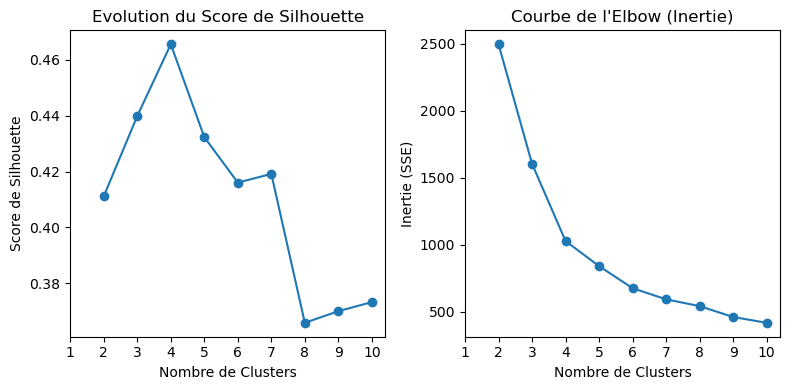

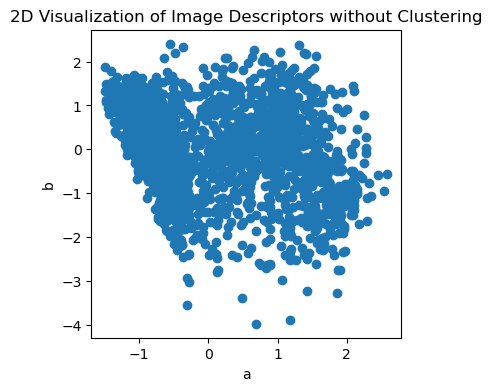

Silhouette optimal : 4 

Inertie optimale : 10


In [4]:
print("Évaluation du meilleur nombre de clusters...")
optimal_k_silhouette, optimal_k_inertia = evaluate_clustering(images,
                                                              color_space=color_space,
                                                              descriptor=descriptor,
                                                              max_clusters=10)
print(f"Silhouette optimal : {optimal_k_silhouette} \n")
print(f"Inertie optimale : {optimal_k_inertia}")


## Model Training

Entraînement avec 4 clusters...


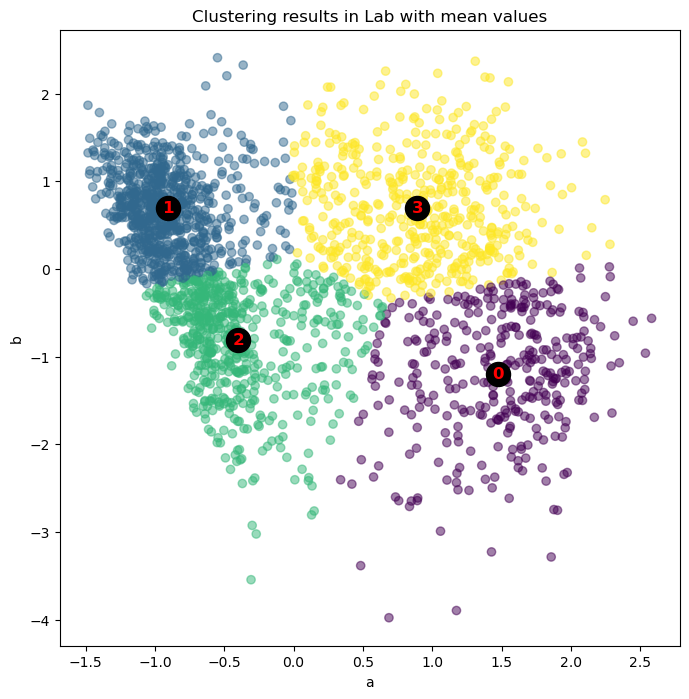

In [5]:
print("Entraînement avec 4 clusters...")
model = StrawberryClassifier(color_space=color_space, descriptor=descriptor, num_clusters=num_clusters)
descriptors, labels, centers = model.train(images)
plot_kmeans_result(descriptors, labels, centers, color_space, descriptor)


## Create dataframe for some results

In [6]:
df = pd.DataFrame(centers, columns=[f"Feature {i+1}" for i in range(centers.shape[1])])
df.insert(0, "Cluster Label", np.arange(len(centers)))
unique_labels, counts = np.unique(labels, return_counts=True)
df["Count"] = counts

distances = cdist(centers, centers, metric='euclidean')
distance_df = pd.DataFrame(distances, columns=[f"Distance to Cluster {i}" for i in range(len(centers))])
df = pd.concat([df, distance_df], axis=1).round(3)
df.to_csv(f"{color_space}-{descriptor}-Clustering.csv", index=False, float_format="%.3f")

print("Résumé des clusters :")
df


Résumé des clusters :


,Cluster Label,Feature 1,Feature 2,Count,Distance to Cluster 0,Distance to Cluster 1,Distance to Cluster 2,Distance to Cluster 3
0,0,1.476,-1.198,346,0.000,3.043,1.915,1.982
1,1,-0.908,0.693,790,3.043,0.000,1.588,1.800
2,2,-0.400,-0.811,582,1.915,1.588,0.000,1.985
3,3,0.891,0.696,491,1.982,1.800,1.985,0.000


## Save images in Folder categories clustering

In [7]:
dossier_sortie = f"{color_space}-{descriptor}-Clustering"
if os.path.exists(dossier_sortie):
    shutil.rmtree(dossier_sortie)
os.makedirs(dossier_sortie, exist_ok=True)

for cluster_num in range(num_clusters):
    os.makedirs(os.path.join(dossier_sortie, f'Cluster_{cluster_num}'), exist_ok=True)

for i, label in enumerate(labels):
    img = images[i]
    image_name = os.path.basename(paths[i])
    save_path = os.path.join(dossier_sortie, f'Cluster_{label}', image_name)
    cv.imwrite(save_path, img)


## Show images

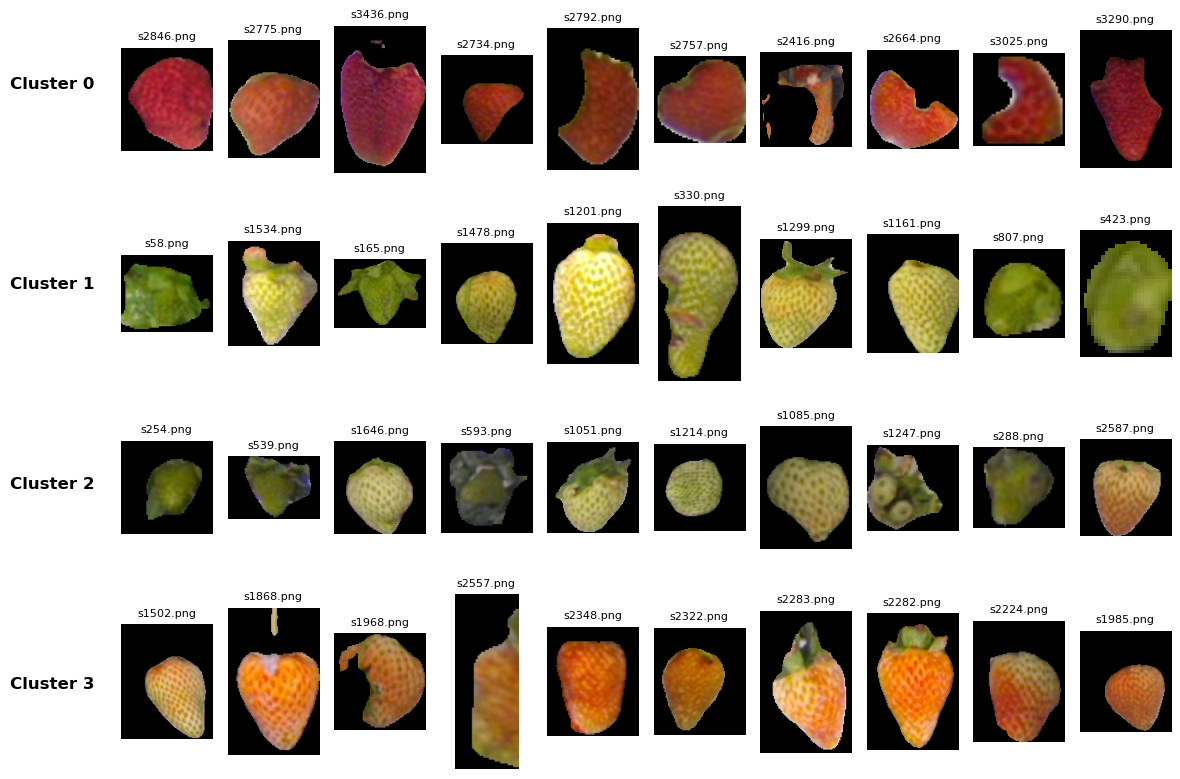

In [8]:
n_cols = 10
n_rows = num_clusters
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

if num_clusters == 1:
    axes = np.array([axes])

for cluster_num in range(num_clusters):
    cluster_dir = os.path.join(dossier_sortie, f'Cluster_{cluster_num}')
    image_files = os.listdir(cluster_dir)
    sample_images = random.sample(image_files, min(n_cols, len(image_files)))

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(cluster_dir, img_name)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        ax = axes[cluster_num, j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_name, fontsize=8)

    fig.text(0.02, 1 - (cluster_num + 0.5) / n_rows, f'Cluster {cluster_num}',
             va='center', ha='left', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.savefig(f"{color_space}-{descriptor}-Clustering.png")
plt.show()


## Model evaluation on test images

Évaluation finale du modèle sur les données de test...


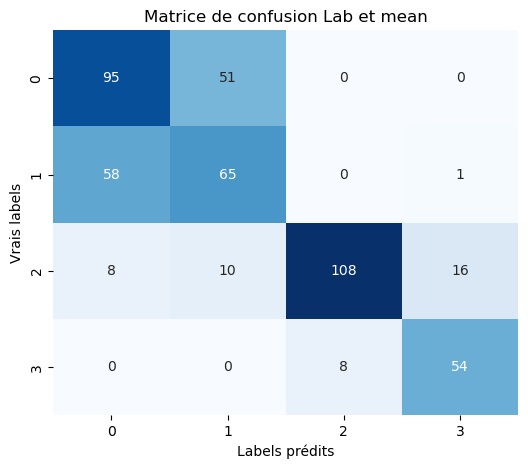

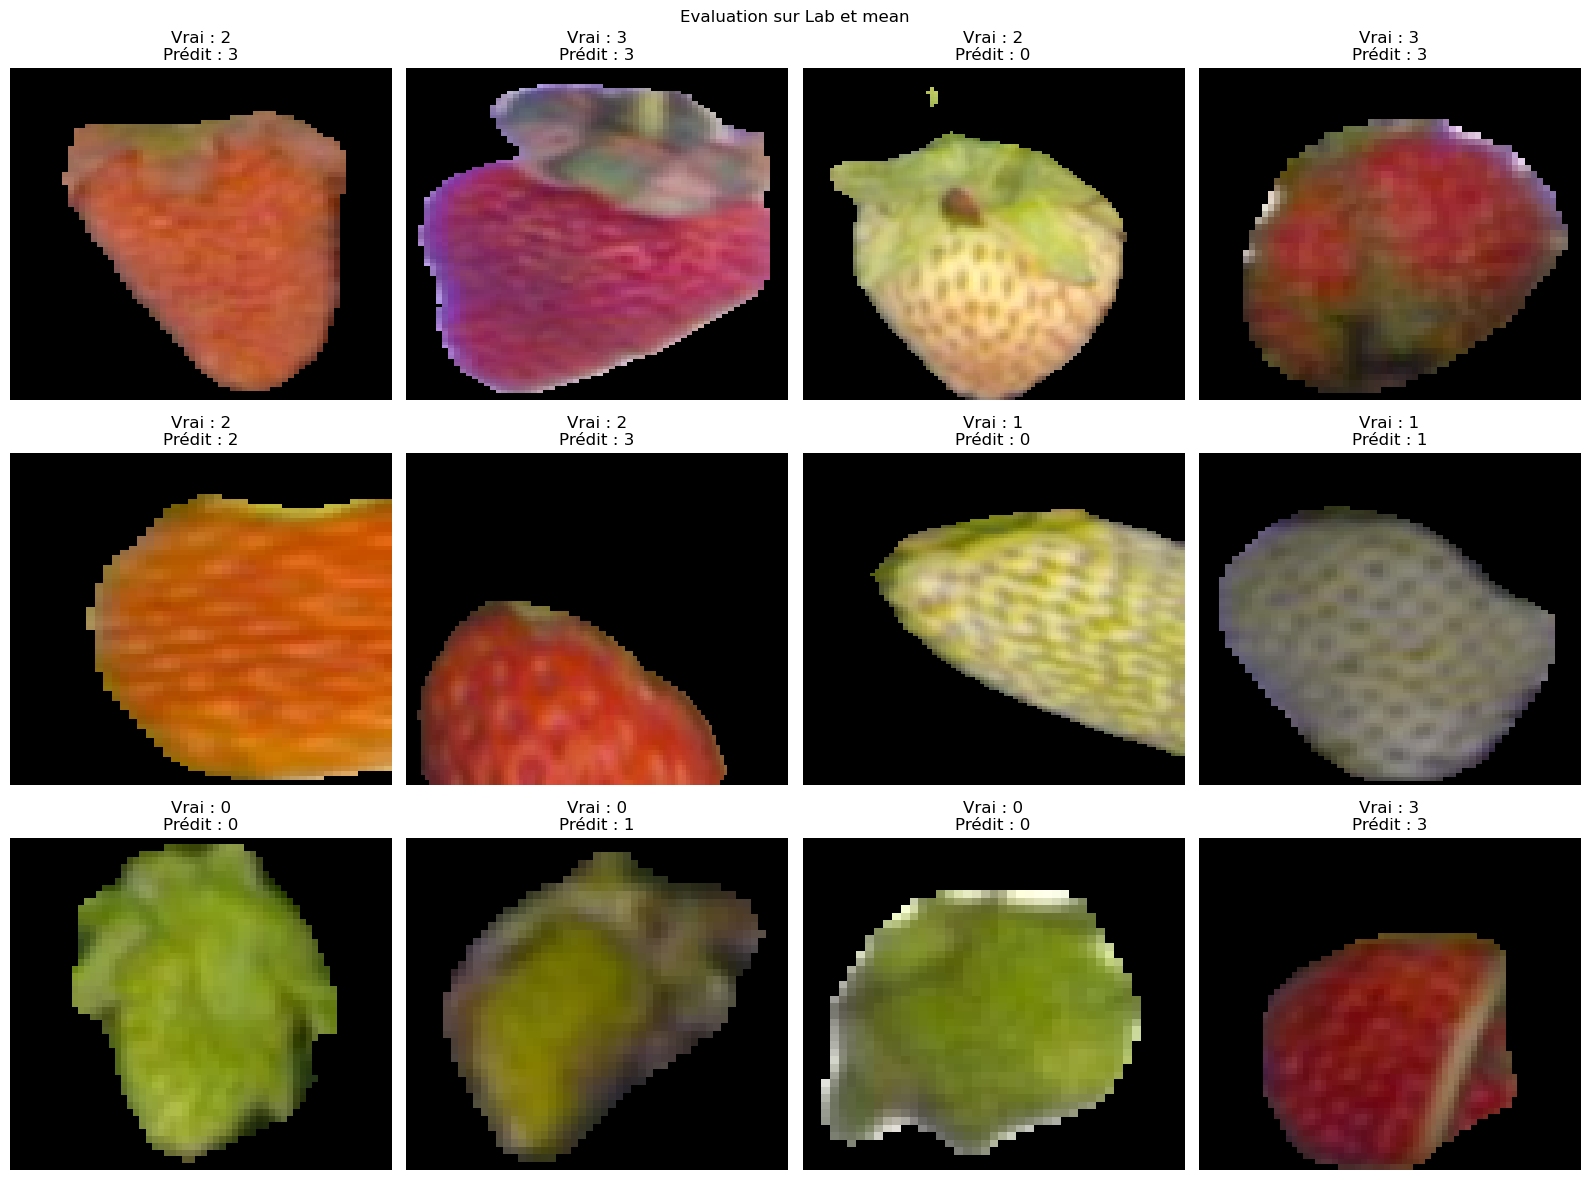

Adjusted Rand Index (ARI): 0.404
Accuracy : 0.679


In [9]:
print("Évaluation finale du modèle sur les données de test...")
test_csv_path  = "../Data/test_labels.csv"
test_images, test_paths = load_images_from_csv(test_csv_path, image_folder)

ARI, accuracy = model.evaluate(test_csv_path, test_images, image_paths=test_paths, n_samples_to_plot=12)
print(f"Adjusted Rand Index (ARI): {ARI:.3f}")
print(f"Accuracy : {accuracy:.3f}")
